## Importing libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools, re
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.models import load_model


## Installing needed libraries

In [37]:
!pip3 -q install imutils

In [39]:
import imutils
from imutils.object_detection import non_max_suppression

# Part 1 : Ship or no ship

## Utility functions

In [ ]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [ ]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
ROOT = r'/content/drive/MyDrive/College/CSCE 5222 - Feature Engineering/Project'
os.chdir(ROOT)
assert os.getcwd() == ROOT

In [ ]:
datasets = ['./Dataset/satellite-imagery-of-ships']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [ ]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(dataset,folder,file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

In [11]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 3000/3000 [15:10<00:00,  3.30it/s]


((4000, 48, 48, 3), (4000,))

## EDA of dataset

In [12]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


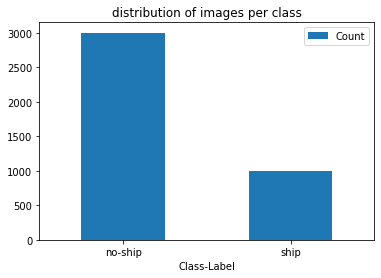

In [13]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

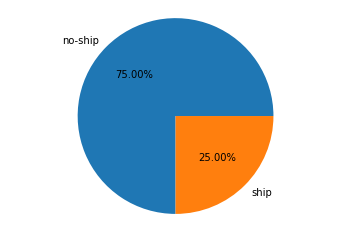

In [14]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

## Augmenting Images of making dataset balanced

In [15]:
AUGMENTATION = True

In [16]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)
    pass

In [17]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [18]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:14, 267.86it/s] 


In [19]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

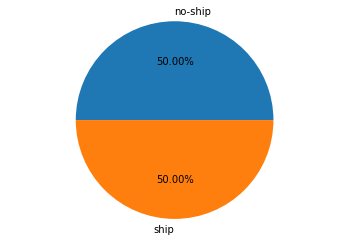

In [20]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

One Hot Encoding Variables

In [21]:
labels = to_categorical(labels)

## Training, Validation and Testing

In [22]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

## Creation of model

In [23]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    return X
    pass

In [24]:
def basic_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5))(X_input)
    
    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)
    
    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(128)(X)
    X = Activation("relu")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')
    
    return model
    pass

In [25]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [26]:
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 58, 58, 3)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 29, 29, 16)       64        
 n)                                                              
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNormal  (None, 29, 

## Compiling the Model

In [27]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

## Training model

In [29]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1, 
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
262/262 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8324
Epoch 00001: val_accuracy improved from -inf to 0.88000, saving model to model_weights.h5
262/262 [==============================] - 20s 9ms/step - loss: 0.3751 - accuracy: 0.8324 - val_loss: 0.3965 - val_accuracy: 0.8800
Epoch 2/50
258/262 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9247
Epoch 00002: val_accuracy improved from 0.88000 to 0.93083, saving model to model_weights.h5
262/262 [==============================] - 2s 8ms/step - loss: 0.1917 - accuracy: 0.9245 - val_loss: 0.1477 - val_accuracy: 0.9308
Epoch 3/50
260/262 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9521
Epoch 00003: val_accuracy did not improve from 0.93083
262/262 [==============================] - 2s 8ms/step - loss: 0.1214 - accuracy: 0.9520 - val_loss: 0.2208 - val_accuracy: 0.9300
Epoch 4/50
258/262 [============================>.] - ETA: 0s - loss: 0.1199 - a

## Plotting Loss and Accuracy

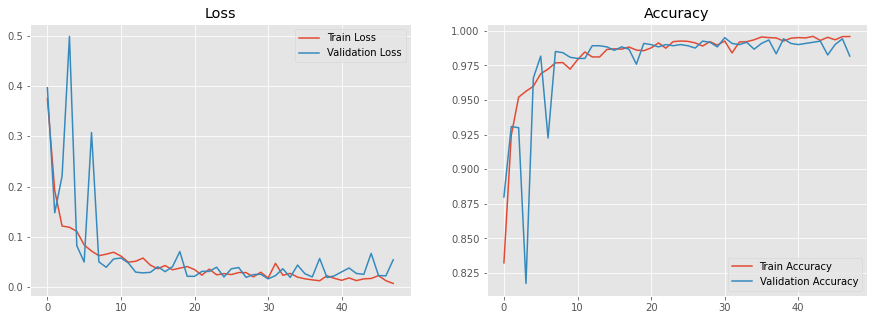

In [30]:
show_final_history(history)

## Confusion Matrix for Validation dataset

In [31]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

(1200,)

<Figure size 432x288 with 0 Axes>

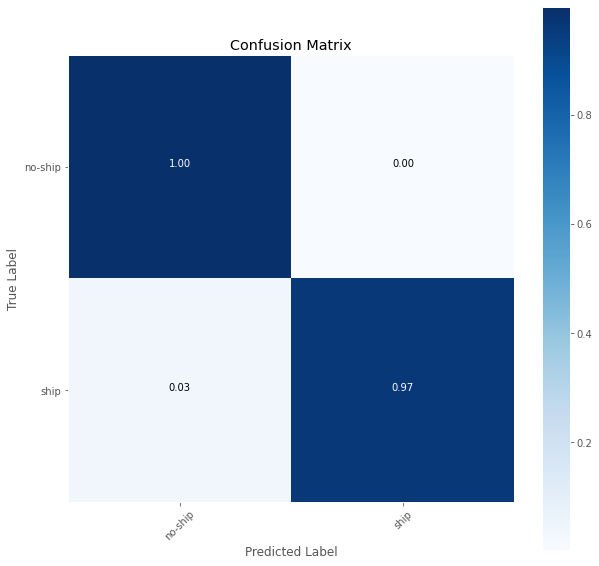

In [32]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

## Confusion Matrix for Testing Dataset

In [33]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

(600,)

<Figure size 432x288 with 0 Axes>

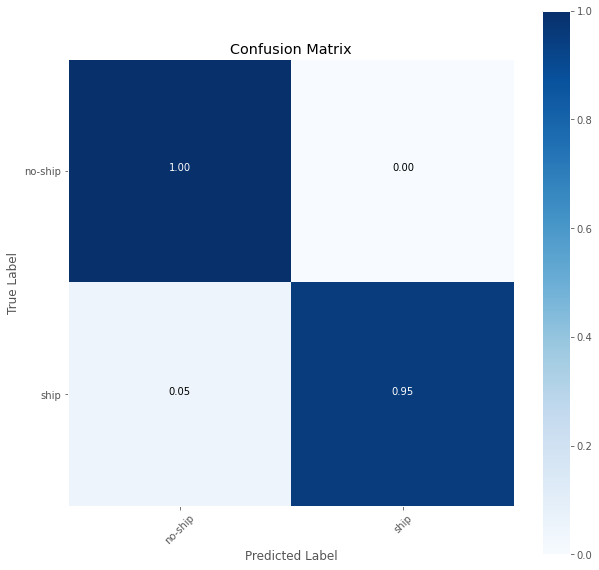

In [34]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

## Checking the model

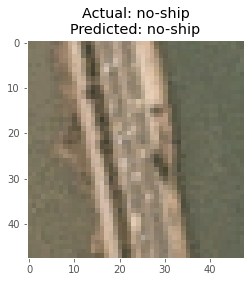

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


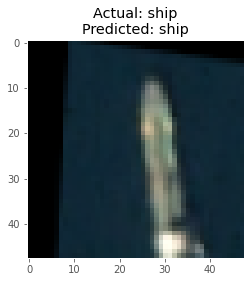

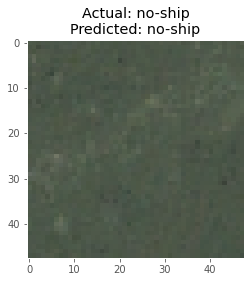

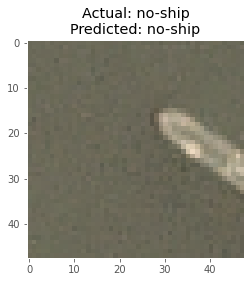

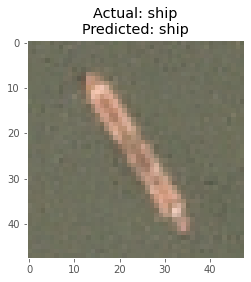

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


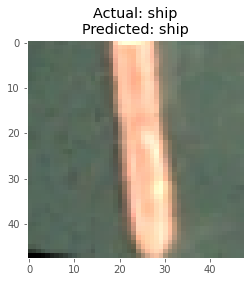

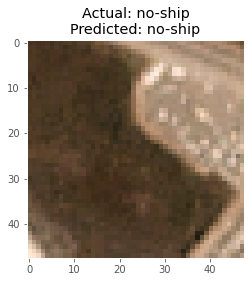

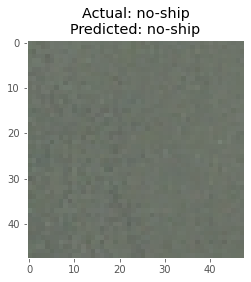

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


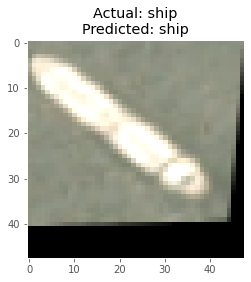

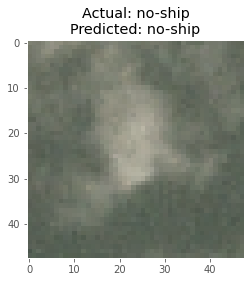

In [35]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

**Saving the model**

In [36]:
model.save("ship-model.h5")

# Part 2 : Ship Detection

## Utitilty Functions

In [40]:
def find_regions(image, method):
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    
    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:
        
        boxes.append([x,y,w,h])
        pass
    
    return boxes
    pass

In [41]:
scene_path = './Dataset/ships-in-satellite-imagery/scenes/scenes'

def load_scenes():
    
    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:
        
        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass
    
    return scenes
    pass

In [42]:
scenes = load_scenes()

./Dataset/ships-in-satellite-imagery/scenes/scenes/lb_1.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/lb_2.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/lb_3.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/lb_4.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/sfbay_1.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/sfbay_2.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/sfbay_3.png
./Dataset/ships-in-satellite-imagery/scenes/scenes/sfbay_4.png


## Finding ROIs

In [43]:
method = "fast"

boxes = []

for scene in scenes:
    
    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

In [44]:
model = load_model('ship-model.h5')

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 58, 58, 3)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 29, 29, 16)       64        
 n)                                                              
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNormal  (None, 29, 

## Predicting the ROIs

In [45]:
rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):
    
    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48,48))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass
    
    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)
    
    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass
    
    images.append(img)
    del rois[:]
    del locs[:]
    pass

8it [00:08,  1.12s/it]


## Displaying final Images

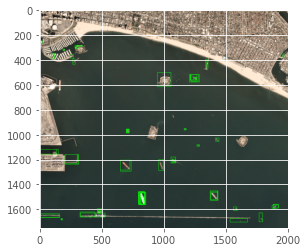

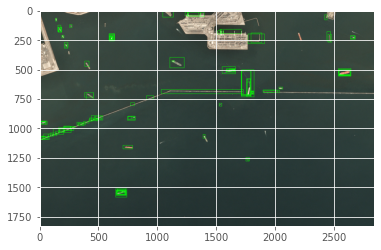

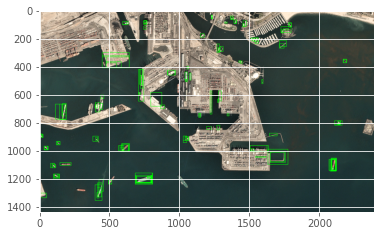

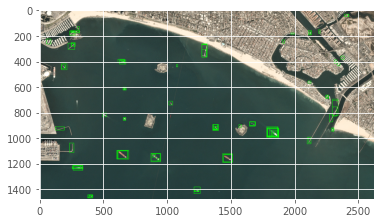

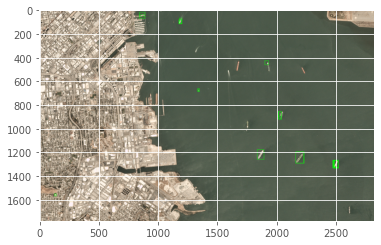

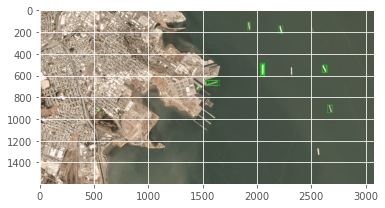

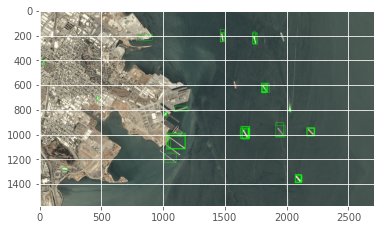

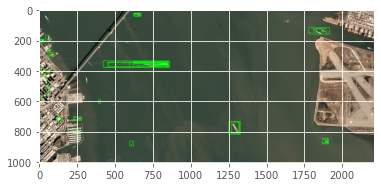

In [46]:
for image in images:
    
    plt.imshow(image)
    plt.show();